In [ ]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

##  <ins>Кейс 1.</ins>

**Контекст**

В связи с постановлением Центрального Банка
наше текущее содержание диалога с клиентом (скрипт)
операторов считается слишком жёстким,
и нам нужно придумать более мягкий скрипт,
который будет всё ещё иметь хорошие показатели.
У нас есть два варианта более мягкого скрипта,
и мы хотим выбрать лучший из них.
При этом у нас нет времени
чтобы ждать вызревания долгих метрик вроде PV.

**Тест**

Мы проводим тест,
в рамках которого мы разбиваем весь поток
на две части рановероятно,
где одной части мы продаём одним вариантом скрипта,
другой - другим.
Целью этого теста
является поиск наилучшего скрипта.

**Статистические вводные**

Уровень значимости 5%.
Мы хотели бы различать 8%-ное
изменение целевой метрики
с вероятностью 80%.

### 1. Выберем целевую метрику.

По условию задачи у нас нет времени, чтобы ждать вызревания долгих метрик вроде PV (а значит и NPV). Поэтому в качестве целевой метрики мы возьмем конверсию в покупку (доля  покупок от количества всех заданий). В исторических данных конверсия составляет 30.22%

In [ ]:
data = pd.read_csv('test1_hist_telesales.csv', sep=',')

In [ ]:
data.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,1,0,90,0,-90
1,1,0,0,5,0,-5
2,2,0,0,68,0,-68
3,3,1,0,22,0,-22
4,4,1,0,22,0,-22


In [ ]:
((data[data['Флаг продажи'] == 1].value_counts('Флаг продажи') / len(data)) * 100).round(decimals=2)

Флаг продажи
1    30.22
dtype: float64

### 2. Альтернатива в критерии.

Сформулируем гипотезу и альтернативу:

H0: p1 = p2. Конверсии в двух группах не имеют значимого различия

H1: p1 != p2. Есть значимое различие в конверсиях

### 3.1. Расчет размера выборки.

В исторических данных для каждого клиента у нас проставлено значение 1, если был факт продажи в результате звонка, и 0 - если не было. Получаем распределение Бернулли.
Размер выборки считаем по формуле:

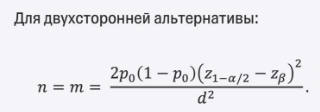

где p0 - базовый коэффициент конверсии (30.2% или 0.302)

In [ ]:
((data[data['Флаг продажи'] == 1].value_counts('Флаг продажи') / len(data)) * 100).round(decimals=2)

Флаг продажи
1    30.22
dtype: float64


d^2 это MDE; Учитывая, что мы хотим выявить 8%-ное изменение целевой метрики, мы можем рассчитать MDE следующим образом:

MDE = 0.08 * 30.2% = 0.024 (2.4% изменения).

Z1-a\2 - Z-значение для желаемого уровня значимости (0.05). Z1-a\2 = 1,96;

In [ ]:
scipy.stats.norm.ppf(1-.05/2)

1.959963984540054

Zβ - Z-значение для желаемой статистической мощности (0.8). Zβ = -0,842

In [ ]:
scipy.stats.norm.ppf(0.2)

-0.8416212335729142

Тогда n = 2*0.302(1-0.302)(1.96-(-0.842))^2 / (0.08 * 0.302)^2 = 5667

### 3.2. Получаем выборки для теста и контроля необходимого размера.

In [ ]:
control = pd.read_csv('test1_control.csv', sep=',')
test = pd.read_csv('test1_test.csv', sep=',')

In [ ]:
# количество продаж в тестовой группе
test[test['Флаг продажи'] == 1].value_counts('Флаг продажи')

Флаг продажи
1    1693
dtype: int64

In [ ]:
# конверсия в тестовой группе
((test[(test['Флаг продажи'] == 1)].value_counts('Флаг продажи') / len(test)) * 100).round(decimals=2)

Флаг продажи
1    29.87
dtype: float64

In [ ]:
# количество продаж в контрольной группе
control[control['Флаг продажи'] == 1].value_counts('Флаг продажи')

Флаг продажи
1    1737
dtype: int64

In [ ]:
# конверсия в контрольной группе
((control[(control['Флаг продажи'] == 1)].value_counts('Флаг продажи') / len(control)) * 100).round(decimals=2)

Флаг продажи
1    30.65
dtype: float64

Построим таблицу сопряженности:

In [ ]:
test = test[['ID', 'Флаг продажи']]

In [ ]:
control = control[['ID', 'Флаг продажи']]

In [ ]:
# добавим колонку для обозначения контрольной\тестовой группы. 1 - тестовая группа
test.insert(loc=1 , column='Group', value=1)

In [ ]:
# 0 - контрольная группа
control.insert(loc=1 , column='Group', value=0)

In [ ]:
# переименуем колонки
test = test.rename(columns={'ID':'Order', 'Флаг продажи':'Status'})
control = control.rename(columns={'ID':'Order', 'Флаг продажи':'Status'})

In [ ]:
# соеденим две таблицы
result = pd.concat([test, control], sort=False, axis=0)

In [ ]:
# построим таблицу сопряженности
table = pd.crosstab(
    result['Group'],
    result['Status'],
    margins = True
)
table

Status,0,1,All
Group,,,
0,3930,1737,5667
1,3974,1693,5667
All,7904,3430,11334


### 4. Проведение теста и принятие решения.

Для сравнения конверсий в двух выборках будем использовать Хи-квадрат Пирсона, т.к он позволяет сравнить отношения количества успеха к неуспехам в двух таблицах. Вспомним нашу гипотезу:

H0: p1 = p2. Конверсии в двух группах не имеют значимого различия

H1: p1 != p2. Есть значимое различие в конверсиях

Число степеней свободы в нашем случае:(rows - 1) * (cols - 1) = (2-1) * (2-1) = 1 * 1 = 1

In [ ]:
# функция принимает на вход таблицу сопряженности и возвращает статистику критерия
def Chisq(table):
    expected = []
    obs1 = np.append(table.iloc[0][0:2].values, table.iloc[1][0:2].values)
    rows = table.iloc[0:2,2].values
    cols = table.iloc[2,0:2].values
    total = table.loc['All','All']
    for count in range(2):
        for column in cols:
            expected.append((rows[count]*column)/total)
    obs = obs1 + 0.5 * np.sign(expected - obs1)
    return sum(((obs - expected)**2)/expected)

In [ ]:
chi = Chisq(table)
chi

0.7729992416284037

In [ ]:
p_value =  1- stats.chi2.cdf(chi,1)

if p_value > 0.05:
    print('Не можем отклонить нулевую гипотезу', '\nХи-квадрат критерий =',Chisq(table),'\np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу','\nХи-квадрат критерий =',Chisq(table),'\np-value = ',p_value)

Не можем отклонить нулевую гипотезу 
Хи-квадрат критерий = 0.7729992416284037 
p-value =  0.37929080919453106


Проверим наш результат с помощью Z-теста:

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

count = np.array([1693, 1737]) # кол-во продаж в каждой выборке
nobs = np.array([5667, 5667]) # кол-во наблюдений в каждой выборке
stat, p_value = proportions_ztest(count, nobs)

alpha = 0.05
if p_value > alpha:
    print('Не можем отклонить нулевую гипотезу \np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу \np-value = ',p_value)

Не можем отклонить нулевую гипотезу 
p-value =  0.3683063516455425


По результатам проведенного теста можно сказать, что у нас нет достаточно оснований, чтобы отвергнуть нулевую гипотез о равенстве конверсий в тестовой и контрольной группе, а значит на данном этапе мы не можем выбрать лучший из двух скриптов.

------------------

##  <ins>Кейс 2.</ins>


**Контекст**

Мы провели Cust Dev и поняли,
что форма авторизации для клиента сложна,
и из-за этого часть клиентов
отваливается в заявочном процессе.
Мы решили разработать
новый процесс авторизации,
и у нас есть гипотеза,
что он позволит повысить
утилизации наших счетов.

**Тест**

Мы проводим тест,
в рамках которого мы разбиваем весь поток
на две части рановероятно,
где у одной части (контроля)
старый процесс авторизации,
а у второй части (теста) - новый.
Целью этого теста
является повышение утилизаций счёта.

**Статистические вводные**

Проверка однородности выбранного параметра
осуществяется с уровнем значимости 2%.

Уровень значимости 5%.
Мы хотели бы различать 3%-ное
изменение целевой метрики
с вероятностью 95%.

In [ ]:
data2 = pd.read_csv('test2_hist_credit_card.csv', sep=',')

In [ ]:
data2.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,19,21620.835463,0.138061,0,102,0,0,-102
1,1,27,24897.990863,0.035508,1,409,11686,1754,13031
2,2,50,23989.526947,0.098793,0,16,0,0,-16
3,3,18,38442.409756,0.365661,1,788,13738,1578,14528
4,4,24,21291.521612,0.036909,1,1048,6594,2213,7759


In [ ]:
data2.shape

(123255, 9)

### 1. Необходимо выбрать метрику и привести аргументацию.

Так как целью теста является повышение утилизаций счёта, то метрикой будет конверсия в утилизацию счета.

In [ ]:
# количество утилизаций в историчесих данных
data2[data2['Флаг утилизации счёта'] == 1].value_counts('Флаг утилизации счёта')

Флаг утилизации счёта
1    91399
dtype: int64

In [ ]:
# конверсия в утилизацию в исторических данных
((data2[data2['Флаг утилизации счёта'] == 1].value_counts('Флаг утилизации счёта') / len(data2)) * 100).round(decimals=2)

Флаг утилизации счёта
1    74.15
dtype: float64

### 2. Альтернатива в критерии.

Сформулируем гипотезу и альтернативу:

H0: p1 = p2. Конверсии в двух группах не имеют значимого различия

H1: p1 > p2. Конверсия в тестовой группе выше

### 3. Выберем параметр(-ы), влияющий(-ие) на целевую метрику.

In [ ]:
age = data2['Возраст'].to_numpy()
income = data2['Доход клиента'].to_numpy()
bancrupt = data2['Вероятность банкротства'].to_numpy()
target_utility = data2['Флаг утилизации счёта'].to_numpy()

In [ ]:
# корреляция между возрастом и целевой метрикой
scipy.stats.pearsonr(age, target_utility, alternative='two-sided')

PearsonRResult(statistic=0.0072766581976316524, pvalue=0.010628710293983797)

In [ ]:
# корреляция между доходом и целевой метрикой
scipy.stats.pearsonr(income, target_utility, alternative='two-sided')

PearsonRResult(statistic=0.0007063099072110418, pvalue=0.8041602344068762)

In [ ]:
# корреляция между вероятностью банкротства и целевой метрикой
scipy.stats.pearsonr(bancrupt, target_utility, alternative='two-sided')

PearsonRResult(statistic=-0.215397874622958, pvalue=0.0)

In [ ]:
# проверим
data2.corr(method='pearson', min_periods=1, numeric_only=False)

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
ID,1.000000,-0.002624,0.004518,0.001279,-0.000964,-0.000077,-0.003181,-0.005220,-0.003480
Возраст,-0.002624,1.000000,0.001514,-0.004102,0.007277,0.002460,0.003447,0.006117,0.003747
Доход клиента,0.004518,0.001514,1.000000,-0.000882,0.000706,0.001032,-0.002142,-0.001937,-0.002269
Вероятность банкротства,0.001279,-0.004102,-0.000882,1.000000,-0.215398,-0.099635,-0.043319,-0.139128,-0.049433
Флаг утилизации счёта,-0.000964,0.007277,0.000706,-0.215398,1.000000,0.452036,0.204981,0.646524,0.233611
Расходы,-0.000077,0.002460,0.001032,-0.099635,0.452036,1.000000,0.090826,0.294538,0.086146
PV КК,-0.003181,0.003447,-0.002142,-0.043319,0.204981,0.090826,1.000000,0.128742,0.998232
PV услуги,-0.005220,0.006117,-0.001937,-0.139128,0.646524,0.294538,0.128742,1.000000,0.183529
NPV,-0.003480,0.003747,-0.002269,-0.049433,0.233611,0.086146,0.998232,0.183529,1.000000


Нас интересует корреляция только с параметрами, которые характеризуют человека (соцдем, параметры нашего скоринга).
Как видно из результатов применения критерия Пирсона наибольшая корреляция (отрицательная) наблюдается между целевой метрикой и вероятностью банкротства.

Коэффициент корреляции – -0.215, а двустороннее значение p – 0,0. Поскольку это значение p меньше 0,05, мы можем заключить, что существует статистически значимая корреляция между двумя переменными.

### 4.1. Расчет размера выборки.

Так как в этом задании мы так же имеем дело со случаем Бернулли, размер выборки рассчитаем по той же формуле, что и в первом задании.

где p0 - базовый коэффициент конверсии (74.15% или 0.741)

d^2 это MDE; Учитывая, что мы хотим выявить 3%-ное изменение целевой метрики, мы можем рассчитать MDE следующим образом:

MDE = 0.03 * 0.741 = 0.022 (2.2% изменения).

Z1-a - Z-значение для желаемого уровня значимости (0.05). Z1-a = 1,64;

In [ ]:
scipy.stats.norm.ppf(1-.05)

1.6448536269514722

Zβ - Z-значение для желаемой статистической мощности (0.95). Zβ = -1,64

In [ ]:
scipy.stats.norm.ppf(0.05)

-1.6448536269514729

Тогда n = 2*0.741(1-0.741)(1.64-(-1.64))^2 / (0.03 * 0.741)^2 = 8358

### 4.2. Получаем выборки для теста и контроля необходимого размера.

In [ ]:
control2 = pd.read_csv('test2_control.csv', sep=',')
test2 = pd.read_csv('test2_test.csv', sep=',')

In [ ]:
test2.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,74,24217.049838,0.206652,1,376,6192,1771,7587
1,1,65,58415.877169,0.149160,0,4,0,0,-4
2,2,44,21011.031878,0.096335,1,123,6167,1383,7427
3,3,34,29045.811689,0.071980,1,132,5300,1569,6737
4,4,47,32321.673508,0.019266,1,513,11546,1679,12712


### 5. Проверка на однородность, применение критерия. Принятие решения.

Для проверки однородности выборок возьмем признак "Вероятность банкротства", как имеющий наибольшую корреляцию с целевой метркой из всех признаков, поступающих для скоринга.

Сформулируем гипотезу и альтернативу:

H0 = выборки однородны, F = F

H1 = выборки не однородны, F != F

Для проверки однородности будем использовать критерий Андерсона-Дарлинга.

In [ ]:
x = control2['Вероятность банкротства'].to_numpy()
y = test2['Вероятность банкротства'].to_numpy()

In [ ]:
import scipy.stats as stats

res = stats.anderson_ksamp([x,y])
p_value = res.pvalue
alpha = 0.02

if p_value > alpha:
    print('Не можем отклонить нулевую гипотезу \np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу \np-value = ',p_value)

Не можем отвергнуть нулевую гипотезу 
p-value =  0.07250131342289769


По результатам теста мы не можем отклонить нулевую гипотезу об однородности выборок, а значит, мы можем провести тест и проверить, действительно ли в тестовой группе наблюдается значительное увеличение конверсии в утилизацию счета.

In [ ]:
# количество утилизаций в контрольной группе
control2[control2['Флаг утилизации счёта'] == 1].value_counts('Флаг утилизации счёта')

Флаг утилизации счёта
1    6175
dtype: int64

In [ ]:
# количество утилизаций в тестовойгруппе
test2[test2['Флаг утилизации счёта'] == 1].value_counts('Флаг утилизации счёта')

Флаг утилизации счёта
1    6437
dtype: int64

Для проверки первоночальной гипотезы используем z-тест. Вспомним нашу гипотезу:

H0: p1 = p2. Конверсии в двух группах не имеют значимого различия

H1: p1 > p2. Конверсия в тестовой группе выше

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

count = np.array([6175, 6437])
nobs = np.array([10070, 10070])
stat, p_val = proportions_ztest(count, nobs, alternative='larger')

alpha = 0.05
if p_value > alpha:
    print('Не можем отклонить нулевую гипотезу \np-value = ',p_value)
else:
    print('Не можем принять нулевую гипотезу \np-value = ',p_value)

Не можем отклонить нулевую гипотезу 
p-value =  0.07250131342289769


В результате проверки гипотезы мы не можем отклонить H0, что может говорить о том, что статистически значимой разницы в конверсиях тестовой и контрольной группы нет.